In [12]:
import numpy as np
import matplotlib.pyplot as plt
import math
from math import log, exp, sqrt, isnan
import pandas as pd

#### Here we define fits and variables

In [3]:
dt = .001 # Time differential

t0 =  0  # intial time
tF = 60  # final time

"""B0 → 71.5717, dBG → 0.065535, deltaB → 0.226845, deltaG → 0.104574,
deltaM → 0.0817739, deltaP → 0.107014, dG → 0.179527, fM → 7.04933, hB → 0.000108336,
hG → 2.34565 × 10-11, lambda → 5.37004, lambdaG → 2.13042, m → 1.80624,
muG → 1.2265 × 107, rB → 6.16541, rG → 0.262815, sigmaA → 0.135469, sigmaN → 0.409708"""

# Constants/fits emaileld
B01 = 72.559
d_BG1 = 0.0635991
delta_B1 = 0.236724
delta_G1 = 0.0982312
delta_M1 = 0.205638
delta_P1 = 0.151396
d_G1 = 0.322589
d_M1 = d_G1 #0.00245009 
d_P1 = d_G1 #0.0161013  
#f_M1 = .5 
f_M1 = 11.0984         # why is f_M this high? it's a probability, so shouldn't it be <= 1?
h_B1 = 0.0000941496
h_G1 = 1.68872*(10**-11)
lam1 = 5.33041
lam_g1 = 2.13481
m1 = 1.82175
mu1 = 1.2274*(10**7)
r_B1 = 6.13599
r_G1 = 0.274329

# Contstants/fits from Mathematica code
B02 = 71.5717
d_BG2 = 0.065535
delta_B2 = 0.226845
delta_G2 = 0.104574
delta_M2 = 0.0817739
delta_P2 = 0.107014
d_G2 = 0.179527
f_M2 = 7.04933
h_B2 = 0.000108336
h_G2 = 2.34565 * (10 ** -11)
lam2 = 5.37004
lam_g2 = 2.13042
m2 = 1.80624
mu2 = 1.2265 * (10 ** 7)
r_B2 = 6.16541
r_G2 = 0.262815

sigma_A2 = 0.135469;
sigma_N2 = 0.409708;


             # 0    1      2         3         4         5         6     7     8     9     10    11      12  13   14    15    16        17
vInit = tuple((B02, d_BG2, delta_B2, delta_G2, delta_M2, delta_P2, d_G2, f_M2, h_B2, h_G2, lam2, lam_g2, m2, mu2, r_B2, r_G2, sigma_A2, sigma_N2))
vNames = tuple(("B0", "d_BG", "delta_B", "delta_G", "delta_M", "delta_P", "d_G", "f_M", "h_B", "h_G", "lam", "lam_g", "m", "mu", "r_B", "r_G", "sigma_A", "sigma_N"))

# Sets if r_Gk is constant or if r_Gk = r_G*sqrt(k)
variabler_G = True

# Intial conditions
A0 = 1
A_g0 = 0

# the number of steps
N = int(round((tF-t0)/dt))

Aarr = np.zeros(N + 1)
Aarr[0] = A0
A_garr = np.zeros(N + 1)
A_garr[0] = A_g0
Barr = np.zeros(N + 1)
Barr[0] = vInit[0]

Garr = np.zeros((4, N + 1))
Marr = np.zeros((4, N + 1))
Parr = np.zeros((4, N + 1))

Gtotarr = np.zeros(N + 1)
Mtotarr = np.zeros(N + 1)
Ptotarr = np.zeros(N + 1)

tarr = np.zeros(N + 1)
tarr[0] = t0


#### Here we set up the arrrays for approximating the model

In [4]:
def reInitArrs(B0):
    global Aarr, A_garr, Barr, Garr, Marr, Parr, Gtotarr, Mtotarr, Ptotarr, tarr
    
    Aarr = np.zeros(N + 1)
    Aarr[0] = A0
    A_garr = np.zeros(N + 1)
    A_garr[0] = A_g0
    Barr = np.zeros(N + 1)
    Barr[0] = B0

    Garr = np.zeros((4, N + 1))
    Marr = np.zeros((4, N + 1))
    Parr = np.zeros((4, N + 1))

    Gtotarr = np.zeros(N + 1)
    Mtotarr = np.zeros(N + 1)
    Ptotarr = np.zeros(N + 1)

    tarr = np.zeros(N + 1)
    tarr[0] = t0


#### Here we have all the equations for the affinity model as laid out in the writeup

In [5]:
#Eqn 1
def dAdt(lam, m, A):
    return (-1 * (lam + m) * A)

#Eqn 2
def dA_gdt(lam_g, m, A, A_g):
    return m * A - lam_g * A_g

#Eqn 3
def dBdt(r_B, h_B, delta_B, d_BG, A, B):
    return r_B * A / (h_B + A) * B - (delta_B + d_BG) * B

    #Eqn 4 and 5
# k is the index on G
#G[k]'[t] == If[k == 1, 1, 0] * dBG * B[t] + (1 - muG / (1 + muG) * If[k == nA, 0, 1]) * rG * Sqrt[k] * Ag[t] / (hG + Ag[t]) * G[k][t] - (deltaG + dG * rG * Sqrt[k] * Ag[t] / (hG + Ag[t])) * G[k][t] + muG / (1 + muG) * 
           # If[k == 1, 0, 1] * rG * Sqrt[k - 1] * Ag[t] / (hG + Ag[t]) * G[k - 1][t], {k, 1, nA}],            
def dG_kdt(k, d_BG, d_G, h_G, delta_G, mu, r_G, A_g, B, G_k, G_kmin1):
    if(k == 1): c0 = 1
    else: c0 = 0
        
    # modifiy n here
    if(k == 3): c1 = 0
    else: c1 = 1
        
    if(k == 1): c2 = 0
    else: c2 = 1
    
    return c0 * d_BG * B + (1 - mu / (1 + mu) * c1) * r_G * math.sqrt(k) * A_g / (h_G + A_g) * G_k - (delta_G + d_G * r_G * math.sqrt(k) * A_g / (h_G + A_g)) * G_k + mu / (1 + mu) * c2 * r_G * math.sqrt(k-1) * A_g / (h_G + A_g) * G_kmin1
    
#Eqn 6
# fM * Exp[-aM * (k - 1)] / (1 + fM * Exp[-aM * (k - 1)]) * dG *G[k][t] * rG * Sqrt[k] * Ag[t] / (hG + Ag[t]) - deltaM * M[k][t],
def dM_kdt(k, f_M, d_G, r_G, h_G, delta_M, A_g, G_k, M_k):
    a_M = .5 # ???? or is it fit?
    return f_M * math.exp(-1 * a_M * (k - 1)) / (1 + f_M * math.exp(-1 * a_M * (k - 1))) * d_G * G_k * r_G * math.sqrt(k) * A_g / (h_G + A_g) - delta_M * M_k

#Eqn 7
#Table[P[k]'[t] == (1 / (1 + fM * Exp[-aM * (k - 1)])) * dG * G[k][t] * rG * Sqrt[k] * Ag[t] / (hG + Ag[t]) - deltaP * P[k][t], {k, 1, nA}]
def dP_kdt(k, f_M, d_G, r_G, h_G, delta_P, A_g, G_k, P_k):
    a_M = .5 
    return (1 / (1 + f_M * math.exp(-a_M * (k - 1)) ) ) * d_G * G_k * r_G * math.sqrt(k) * A_g / (h_G + A_g) - delta_P * P_k


#### The main function of the model. 
It utilizes the Euler method for approximating systems of differential equations:
https://en.wikipedia.org/wiki/Euler_method
There may be limitations (esp w/ small time steps) when using this method

In [6]:
# Euler method
def euler(v):
    global Aarr, A_garr, Barr, tarr, Garr, Parr, Marr, Gtotarr, Mtotarr, Ptotarr
    
    (B0, d_BG, delta_B, delta_G, delta_M, delta_P, d_G, f_M, h_B, h_G, lam, lam_g, m, mu, r_B, r_G, sigma_A, sigma_N) = v
    reInitArrs(B0)
    
    for i in range(1, N + 1):
        #f_M = .5
        A = Aarr[i - 1]
        A_g = A_garr[i - 1]
        B = Barr[i - 1]
        t = tarr[i - 1]
        Aarr[i] = A + dt * dAdt(lam, m, A)
        A_garr[i] = A_g + dt * dA_gdt(lam_g, m, A, A_g)
        Barr[i] = B + dt * dBdt(r_B, h_B, delta_B, d_BG, A, B)
    
        for k in range(1, 4):
            G_k = Garr[k, i - 1]
            G_kmin1 = Garr[k - 1, i - 1]
            P_k = Parr[k, i - 1]
            M_k = Marr[k, i - 1]
            Garr[k, i] = G_k + dt * dG_kdt(k, d_BG, d_G, h_G, delta_G, mu, r_G, A_g, B, G_k, G_kmin1)
            Marr[k, i] = M_k + dt * dM_kdt(k, f_M, d_G, r_G, h_G, delta_M, A_g, G_k, M_k)
            Parr[k, i] = P_k + dt * dP_kdt(k, f_M, d_G, r_G, h_G, delta_P, A_g, G_k, P_k)

            Gtotarr[i] += Garr[k, i]
            Ptotarr[i] += Parr[k, i]
            Mtotarr[i] += Marr[k, i]
            
    
        tarr[i] = t + dt
    
    for i in range(1, len(Barr)):
        Barr[i]+= B0

#### Here, we extract expiremental data from csv's to plot w/ model

In [7]:
# Cell counts for  PBs GCBs and MCs
csv = pd.read_csv('data-Bcell-dynamics-edited-permouse.csv', index_col = 'day', names=['day','PB','GC','MC'])
Stimes = csv.index.values[1:-1].astype('int')
Spb = csv.PB.values[1:-1].astype('double')
Sgc = csv.GC.values[1:-1].astype('double')
Smc = csv.MC.values[1:-1].astype('double')

# Cell counts for PC's
xlsx = pd.read_excel('LLPC_total_numbers.xlsx', index_col = 'day', names =['day','zero','one','two','three'])
Stimes2 = xlsx.index.values[0:4].astype('int')
Stimes2 = np.repeat(Stimes2, 4)
Spc = np.zeros(16)
for i in range (0, 4):
    Spc[4*i + 0] = xlsx.zero.values[i].astype('double')
    Spc[4*i + 1] = xlsx.one.values[i].astype('double')
    Spc[4*i + 2] = xlsx.two.values[i].astype('double')
    Spc[4*i + 3] = xlsx.three.values[i].astype('double')

# Cell affinities
csv2 = pd.read_csv('data-IgHg2A10_affinity-cleaned.csv', index_col = 'day', names = ['day', 'AA', 'celltype', 'mouse'])
csv2.sort_values(by = 'day')
Sapbt, Sagct, Samct, Sapct = [], [], [], []
Sapb, Sagc, Samc, Sapc = [], [], [], []

for i in range(len(csv2.index)):
    if(csv2.celltype.values[i] == "PB"):
        Sapbt.append(int(csv2.index.values[i]))
        Sapb.append(float(csv2.AA.values[i]))
    if(csv2.celltype.values[i] == "GC"):
        Sagct.append(int(csv2.index.values[i]))
        Sagc.append(float(csv2.AA.values[i]))
    if(csv2.celltype.values[i] == "MC" or csv2.celltype.values[i] == "MBC"):
        Samct.append(int(csv2.index.values[i]))
        Samc.append(float(csv2.AA.values[i]))
    if(csv2.celltype.values[i] == "PC"):
        Sapct.append(int(csv2.index.values[i]))
        Sapc.append(float(csv2.AA.values[i]))

In [8]:
def calcAA():
    global Garr, Gtotarr, Marr, Mtotarr, Parr, Ptotarr, Barr
    
    BAarr, GAarr, MAarr, PAarr = np.zeros((N + 1)), np.zeros((N + 1)), np.zeros((N + 1)), np.zeros((N + 1))
    avgPBA = 0
    k = 0
    for i in Sapb:
        if(math.isnan(i)):
            continue
        avgPBA += i
        k += 1
    avgPBA = avgPBA / k
    
    for i in range(N+1):
        
        avgG, avgM, avgP = 0, 0, 0
        for j in range(1, 4):
            avgG += Garr[j, i] * j
            avgM += Marr[j, i] * j
            avgP += Parr[j, i] * j
            
        totG = Gtotarr[i]
        totM = Mtotarr[i]
        totP = Ptotarr[i]
        if(totG == 0): totG = 1
        if(totM == 0): totM = 1
        if(totP == 0): totP = 1
        avgG = avgG/totG
        avgM = avgM/totM
        avgP = avgP/totP 
    
        BAarr[i] = avgPBA 
        GAarr[i] = avgG
        MAarr[i] = avgM
        PAarr[i] = avgP
        
    return [BAarr, GAarr, MAarr, PAarr]


In [14]:
def NLL(v):
    
    euler(v)
    
    # Scatter number, model number of cells
    snt = [Stimes, Stimes, Stimes, Stimes2]
    sn = [Spb, Sgc, Smc, Spc]
    mn = [Barr, Gtotarr, Mtotarr, Ptotarr]
    
    sat = [Sapbt, Sagct, Samct, Sapct]
    sa = [Sapb, Sagc, Samc, Sapc]
    ma = calcAA()
    
    sum1 = 0
    n1 = 0
    for j in range(4):
        k = 0
        for i in snt[j]:
            actual = sn[j][k]
            predicted = mn[j][int(i/dt)]
            k += 1
            if(actual <= 0 or predicted <= 0 or math.isnan(actual)): continue
            n1 += 1
            sum1 += ( (math.log(actual, 10) - math.log(predicted, 10)) ** 2 ) / (2 * (v[-1] ** 2))
            #print(j, i, actual, predicted, sum1)
    
    sum2 = 0       
    n2 = 0
    for j in range(4):
        k = 0
        for i in sat[j]:
            actual = sa[j][k]
            predicted = ma[j][int(i/dt)]
            k += 1
            if(math.isnan(actual)): continue
            n2 += 1
            sum2 += ((actual- predicted) ** 2) / (2 * (v[-2] ** 2))
            #print(j, i, actual, predicted, sum2)
        
    #n1 = len(Stimes)
    #n2 = len(Sapbt) # This does make it so that we are using n1/n2 unrelated to what we have summed over
    
    
    #print(sum1)
    #print(sum2)
        
    # Also, the base for logs just changes here for no reason????
    return (sum1 + sum2 + (n1 * math.log(v[-1])) + (n2 * math.log(v[-2])))

print(NLL(vInit))

-76.34287972274825


#### Here, we run the model and graph the results

(71.5717, 0.065535, 0.226845, 0.104574, 0.0817739, 0.107014, 0.179527, 7.04933, 0.000108336, 2.3456499999999998e-11, 5.37004, 2.13042, 1.80624, 12265000.0, 6.16541, 0.262815, 0.135469, 0.409708)
-76.34287972274825


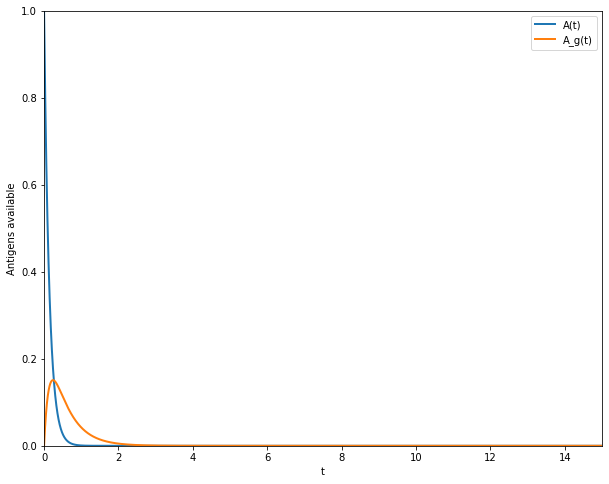

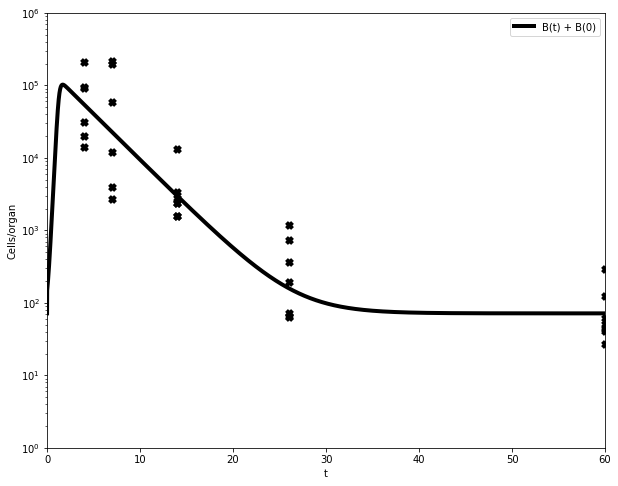

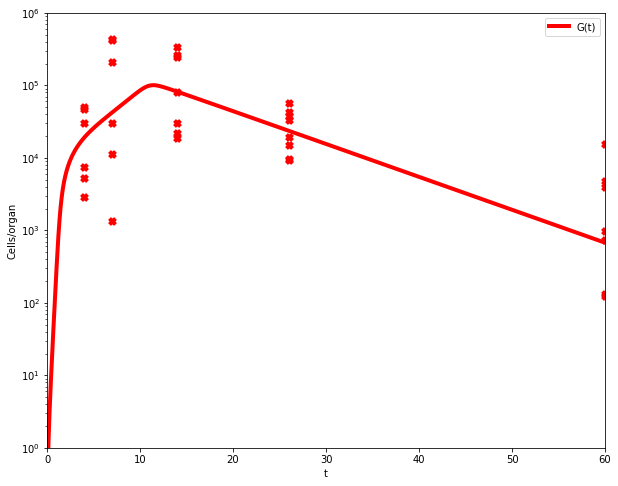

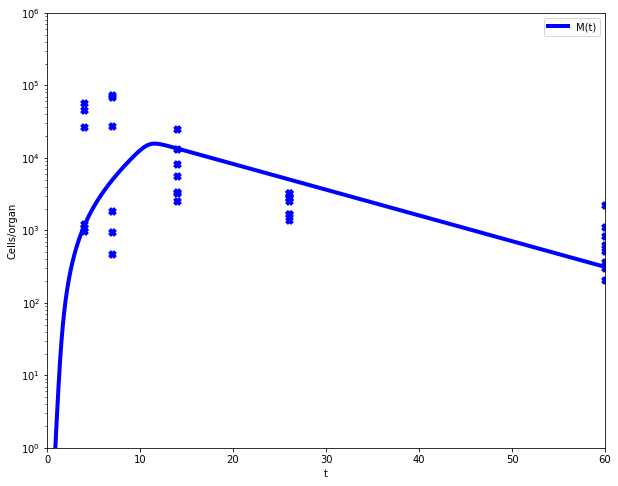

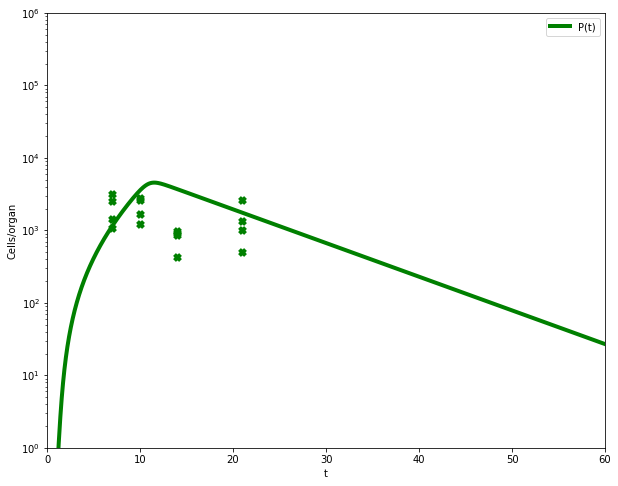

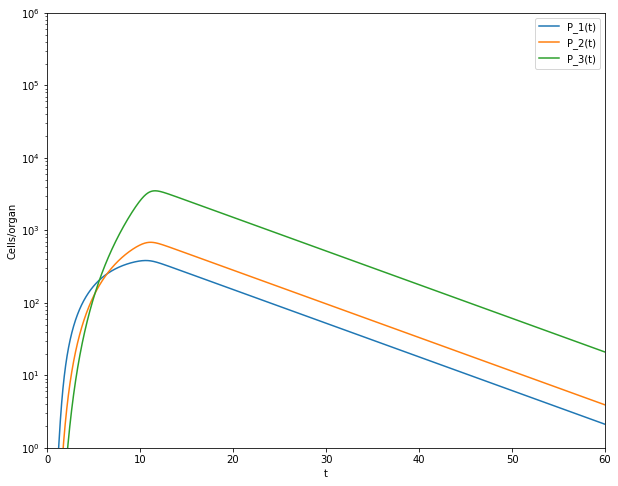

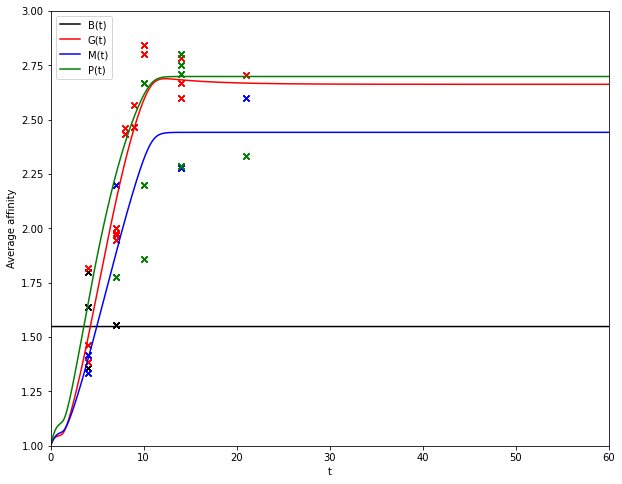

In [10]:
# Call the function to run the model so we can graph

# here are the variables w/ the lowest SSR i got with gradient descent. SSR: 5.148666e+11
# (71.59205434857685, 0.06806932130591119, 0.2104126492314999, 0.09116913023495661, 0.08178938340112435, 0.10701968476189978, 0.17310394397234516, 7.049336642090847, 7.10792496e-05, 1.8724084774374178e-11, 5.252497501199031, 2.1041403856757808, 1.7679069783484835, 12265000.0, 6.313904193296472, 0.19885356550859085, 0.135469, 0.409708)

print(vInit)
print(NLL(vInit))

# Graph of antigens available
fig1 = plt.figure()
fig1.set_size_inches(10,8)

plt.plot(tarr, Aarr, label = "A(t)", linewidth = 2)
plt.plot(tarr, A_garr, label = "A_g(t)", linewidth = 2)

plt.xlabel("t")
plt.ylabel("Antigens available")

plt.axis([t0, tF, 0, 1])

plt.legend()
plt.show()

#Plasmablasts graph

fig2 = plt.figure()
fig2.set_size_inches(10,8)

plt.plot(tarr, Barr, linewidth = 4, label = "B(t) + B(0)", color = 'black')
plt.scatter(Stimes, Spb, linewidth = 4, marker = 'x', color = 'black')

plt.xlabel("t")
plt.ylabel("Cells/organ")
plt.xscale("linear")
plt.yscale("log")
plt.axis([t0, tF, 1, 10**6])

plt.legend()
plt.show()

# GC B cells graph

fig3 = plt.figure()
fig3.set_size_inches(10,8)

plt.plot(tarr, Gtotarr, linewidth = 4, label = "G(t)", color = 'red')
plt.scatter(Stimes, Sgc, linewidth = 4, marker = 'x', color = 'red')

plt.xlabel("t")
plt.ylabel("Cells/organ")
plt.xscale("linear")
plt.yscale("log")
plt.axis([t0, tF, 1, 10**6])

plt.legend()
plt.show()

# MCB cells graph

fig4 = plt.figure()
fig4.set_size_inches(10,8)

plt.plot(tarr, Mtotarr, linewidth = 4, label = "M(t)", color = 'blue')
plt.scatter(Stimes, Smc, linewidth = 4, marker = 'x', color = 'blue')

plt.xlabel("t")
plt.ylabel("Cells/organ")
plt.xscale("linear")
plt.yscale("log")
plt.axis([t0, tF, 1, 10**6])

plt.legend()
plt.show()

# Plasma cells graph

fig5 = plt.figure()
fig5.set_size_inches(10,8)

plt.plot(tarr, Ptotarr, linewidth = 4, label = "P(t)", color = 'green')
plt.scatter(Stimes2, Spc, linewidth = 4, marker = 'x', color = 'green')

plt.xlabel("t")
plt.ylabel("Cells/organ")
plt.xscale("linear")
plt.yscale("log")
plt.axis([t0, tF, 1, 10**6])

plt.legend()
plt.show()

# Graph of GC B cell affinities 

fig6 = plt.figure()
fig6.set_size_inches(10,8)


plt.plot(tarr, Parr[1], label = "P_1(t)")
plt.plot(tarr, Parr[2], label = "P_2(t)")
plt.plot(tarr, Parr[3], label = "P_3(t)")
plt.xlabel("t")
plt.ylabel("Cells/organ")
plt.yscale("log")
plt.axis([t0, tF, 1, 10**6])

plt.legend()
plt.show

# Average affinities
fig7 = plt.figure()
fig7.set_size_inches(10,8)

plt.plot(tarr, calcAA()[0], label = "B(t)", color = 'black')
plt.scatter(Sapbt, Sapb, marker = 'x', color = 'black')
plt.plot(tarr, calcAA()[1], label = "G(t)", color = 'red')
plt.scatter(Sagct, Sagc, marker = 'x', color = 'red')
plt.plot(tarr, calcAA()[2], label = "M(t)", color = 'blue')
plt.scatter(Samct, Samc, marker = 'x', color = 'blue')
plt.plot(tarr, calcAA()[3], label = "P(t)", color = 'green')
plt.scatter(Sapct, Sapc, marker = 'x', color = 'green')


plt.xlabel("t")
plt.ylabel("Average affinity")
plt.axis([t0, tF, 1.0, 3.0])

plt.legend()
plt.show()

#### Here, we start fitting variables to the data using gradient descent

It is currently set to use SSR for this. This does not seem to be a good function to use for fitting the graph, as fits with less SSR don't look as good as the init fit.

In [15]:
learningRate = .1

def grad(v):
    nll1 = NLL(v)
    
    nlllist.append(nll1)
    print(nll1)
    
    grad = tuple(())
    
    for i in range(0, len(v)):
        #dV = 10 ** (math.floor(math.log(v[i], 10)) - 1)
        dV = .1
        v2 = v[0:i] + tuple((v[i] + dV, )) + v[i+1:]
        dnll = NLL(v2) - nll1
        
        print('  dV of ', dV, ' on ', vNames[i], ' got nll of', dnll + nll1, ' for a dnll ', dnll)
        
        grad += tuple((dnll/dV, ))
    
    print('  grad =', grad)
    
    return grad
    
def deltaV(grad, v):
    gMax = max(np.absolute(grad))
    gMin = min(np.absolute(grad))
        
    deltaV = tuple(())
    for i in range(0, len(v)):
        if (grad[i] == 0.0): deltaV += tuple((0.0,))
        else: deltaV += tuple(((-1 * (grad[i]/abs(grad[i])) * (abs(grad[i]/gMax)) * v[i] * learningRate),))
    
    return deltaV
        
              
def gradDescent(v):
    strikes = 0 # just like baseball, if it misses 3 times we stop
    for i in range (1, 100):
        nllOld = NLL(v)
        
        print(i)
        print('v = ', v)
        
        dV = deltaV(grad(v), v)
        print('dV = ', dV)
        
        newV = tuple(())
        
        for j in range(0, len(v)):
            newV += tuple((v[j] + dV[j], ))
        
        nllNew = NLL(newV)
        
        if(nllNew > nllOld): 
            if(strikes == 0): goodV = v
            strikes += 1
            if(strikes >= 2):
                return goodV
            
        else: 
            strikes = 0
            v = newV
            
    
    return v

nlllist = list((NLL(vInit),))
v = gradDescent(vInit)

print(nlllist)

1
v =  (71.5717, 0.065535, 0.226845, 0.104574, 0.0817739, 0.107014, 0.179527, 7.04933, 0.000108336, 2.3456499999999998e-11, 5.37004, 2.13042, 1.80624, 12265000.0, 6.16541, 0.262815, 0.135469, 0.409708)
-76.34287972274825
  dV of  0.1  on  B0  got nll of -76.34661394529337  for a dnll  -0.003734222545119792
  dV of  0.1  on  d_BG  got nll of -32.291086048669115  for a dnll  44.051793674079136
  dV of  0.1  on  delta_B  got nll of -48.9345970700557  for a dnll  27.40828265269255
  dV of  0.1  on  delta_G  got nll of 90.01534000681397  for a dnll  166.35821972956222
  dV of  0.1  on  delta_M  got nll of 68.64411023041231  for a dnll  144.98698995316056
  dV of  0.1  on  delta_P  got nll of -61.04167198766771  for a dnll  15.301207735080538
  dV of  0.1  on  d_G  got nll of -80.35869817706828  for a dnll  -4.015818454320026
  dV of  0.1  on  f_M  got nll of -76.2594362286219  for a dnll  0.08344349412635665
  dV of  0.1  on  h_B  got nll of 1549.4836514000099  for a dnll  1625.826531122758

-79.17996751975664
  dV of  0.1  on  B0  got nll of -79.17408159505953  for a dnll  0.005885924697111022
  dV of  0.1  on  d_BG  got nll of -35.4041922015748  for a dnll  43.77577531818184
  dV of  0.1  on  delta_B  got nll of -56.87989807790876  for a dnll  22.30006944184788
  dV of  0.1  on  delta_G  got nll of 82.61237898500195  for a dnll  161.7923465047586
  dV of  0.1  on  delta_M  got nll of 59.60874848529164  for a dnll  138.7887160050483
  dV of  0.1  on  delta_P  got nll of -64.64064976979438  for a dnll  14.539317749962265
  dV of  0.1  on  d_G  got nll of -80.82485671543128  for a dnll  -1.6448891956746365
  dV of  0.1  on  f_M  got nll of -79.10679421088008  for a dnll  0.07317330887656226
  dV of  0.1  on  h_B  got nll of 1534.1796542508825  for a dnll  1613.3596217706393
  dV of  0.1  on  h_G  got nll of 7343.93738956161  for a dnll  7423.117357081366
  dV of  0.1  on  lam  got nll of -78.62680302108822  for a dnll  0.5531644986684228
  dV of  0.1  on  lam_g  got nll of 

-80.49079841829234
  dV of  0.1  on  B0  got nll of -80.47550292636657  for a dnll  0.015295491925769511
  dV of  0.1  on  d_BG  got nll of -37.05311781658122  for a dnll  43.43768060171112
  dV of  0.1  on  delta_B  got nll of -63.26000500073752  for a dnll  17.23079341755482
  dV of  0.1  on  delta_G  got nll of 76.87375635121555  for a dnll  157.3645547695079
  dV of  0.1  on  delta_M  got nll of 52.30237369289853  for a dnll  132.79317211119087
  dV of  0.1  on  delta_P  got nll of -66.70097216080734  for a dnll  13.789826257485004
  dV of  0.1  on  d_G  got nll of -79.85251405366665  for a dnll  0.6382843646256902
  dV of  0.1  on  f_M  got nll of -80.42781406961689  for a dnll  0.06298434867545666
  dV of  0.1  on  h_B  got nll of 1520.3397037909176  for a dnll  1600.83050220921
  dV of  0.1  on  h_G  got nll of 7303.41659219059  for a dnll  7383.9073906088815
  dV of  0.1  on  lam  got nll of -80.82470274263517  for a dnll  -0.333904324342825
  dV of  0.1  on  lam_g  got nll of 

#### Here, we define a sum of square residuals function to evaluate each model

In [ ]:
def SSR(scatterTimes, scatterVals, valArr):
    j = 0
    ssr = 0.0
    for i in scatterTimes:
        actual = scatterVals[j]
        pred = valArr[int(i / dt)]
        sr = (actual - pred) * (actual - pred)
        ssr += sr
        #print(i, j, actual, pred, sr, ssr)
        j += 1
        
    return ssr

# 

In [ ]:
def SSRAll(v):
    global Stimes, Spb, tarr, Barr, Sgc, Gtotarr, Smc, Mtotarr, Stimes2, Spc, Ptotarr
    euler(v)
    ssrAll = 0.0
    ssrAll = SSR(Stimes, Spb, Barr)
    ssrAll += SSR(Stimes, Sgc, Gtotarr)
    ssrAll += SSR(Stimes, Smc, Mtotarr)
    ssrAll += SSR(Stimes2, Spc, Ptotarr)
    
    return ssrAll